# Expression of single-cell

This notebook analysis the correlation between single-cell.

In [1]:
import gzip
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

## 1. Make counts matrix

In [2]:
params = [
    {"s4U": 0, "min_tc": 0},
    {"s4U": 50, "min_tc": 0.008}
]

for param in params:
    print("-" * 80)
    print(param)
    s4u, min_tc = param["s4U"], param["min_tc"]
    d = pd.read_csv("../../1_FLAIRseq/reports/FLAIRseq_Summary.tsv", sep="\t")
    d = d[d["CellLine"] == "K562"]
    d = d[d["Time"] == 3]
    d = d[d["s4U"] == s4u]
    d = d[d["ActD"].isna()]
    d = d[d["UMIs"] >= 5000]
    d = d[d["TC.Ratio"] >= min_tc]
    print("Cells:", len(d))
    
    data = dict()
    for run, cell in d[["Run", "Cell"]].values:
        path1 = "../../1_FLAIRseq/results/expression/sqanti3/%s/%s/%s_classification.txt" % (run, cell, cell)
        df1 = pd.read_csv(path1, sep="\t", header=0, index_col=0)
        path2 = "../../1_FLAIRseq/results/mapping/mark_duplicate/%s/%s.tsv" % (run, cell)
        df2 = pd.read_csv(path2, sep="\t")
        df2 = df2[["UMI", "AllSize"]]
        df = df1.merge(df2, left_index=True, right_on="UMI")
        df.index = df["UMI"]
        data[cell] = df    
    
    categories = ["full-splice_match", "incomplete-splice_match", "novel_in_catalog", "novel_not_in_catalog"]
    array1 = []
    array2 = []
    array3 = []
    for cell, d in data.items():
        d = d[[x in categories for x in d["structural_category"]]]
        counter1 = defaultdict(int) # read-based
        counter2 = defaultdict(int) # umi-based
        counter3 = defaultdict(int) # umi-based (reads > 1)
        for gid, reads in d[["associated_gene", "AllSize"]].values:
            counter1[gid] += reads
            counter2[gid] += 1
            if reads >= 2:
                counter3[gid] += 1
        s1 = pd.Series(counter1, name=cell)
        s2 = pd.Series(counter2, name=cell)
        s3 = pd.Series(counter3, name=cell)
        array1.append(s1)
        array2.append(s2)
        array3.append(s3)
    
    m1 = pd.concat(array1, axis=1).fillna(0) # read-based
    m1.index.name = "GeneID"
    m2 = pd.concat(array2, axis=1).fillna(0) # umi-based
    m2.index.name = "GeneID"
    m3 = pd.concat(array3, axis=1).fillna(0) # umi-based (reads > 1)
    m3.index.name = "GeneID"
    
    m1.to_csv("results/K562_counts.%duM_3h.%dcells.read_based.tsv" % (s4u, len(m1.columns)), sep='\t')
    m2.to_csv("results/K562_counts.%duM_3h.%dcells.umi_based.tsv" % (s4u, len(m2.columns)), sep='\t')
    m3.to_csv("results/K562_counts.%duM_3h.%dcells.umi2_based.tsv" % (s4u, len(m3.columns)), sep='\t')

--------------------------------------------------------------------------------
{'s4U': 0, 'min_tc': 0}
Cells: 190
--------------------------------------------------------------------------------
{'s4U': 50, 'min_tc': 0.008}
Cells: 105


## 2. Cell-to-cell correlation

In [25]:
m1 = pd.read_csv("results/K562_counts.0uM_3h.190cells.read_based.tsv", sep="\t", header=0, index_col=0)
m2 = pd.read_csv("results/K562_counts.0uM_3h.190cells.umi_based.tsv", sep="\t", header=0, index_col=0)
m3 = pd.read_csv("results/K562_counts.0uM_3h.190cells.umi2_based.tsv", sep="\t", header=0, index_col=0)
ms = [m1, m2, m3]

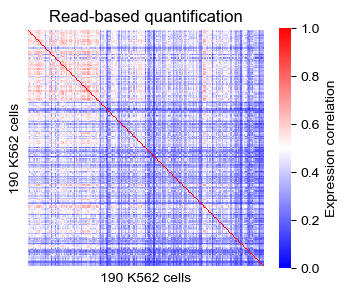

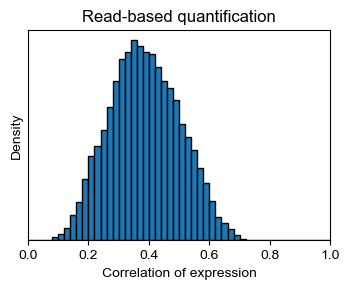

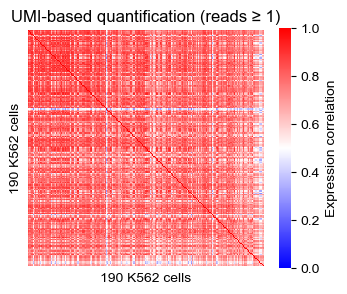

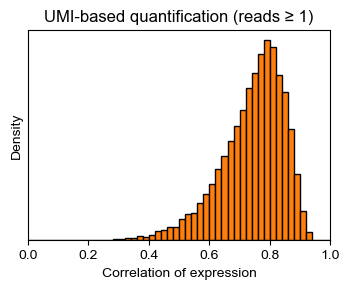

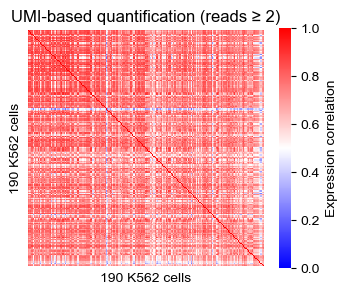

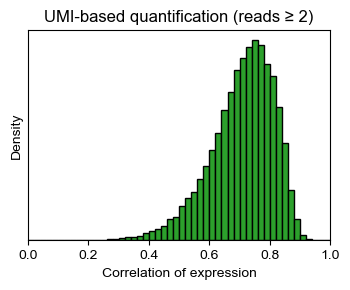

In [26]:
def get_corr_array(corr):
    vs = []
    for i in range(len(corr)):
        for j in range(len(corr)):
            if i < j:
                vs.append(corr.values[i][j])
    return np.array(vs)

names = ["read_based", "umi_based", "umi_based_2"]

for i, m in enumerate(ms):
    name = names[i]
    corr = m.corr()
    
    if i == 0:
        title = "Read-based quantification"
    elif i == 1:
        title = "UMI-based quantification (reads ≥ 1)"
    elif i == 2:
        title = "UMI-based quantification (reads ≥ 2)"
    
    # heatmap
    if True:
        plt.figure(figsize=(3.6, 3))
        plt.title(title)
        sns.heatmap(corr, cmap="bwr", vmin=0, vmax=1, square=True, cbar_kws={"label": "Expression correlation"})
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("%d K562 cells" % len(corr))
        plt.ylabel("%d K562 cells" % len(corr))
        plt.tight_layout()
        plt.savefig("figures/correlation.heatmap.k562.%s.pdf" % name)
        
    # density
    if True:
        vs = get_corr_array(corr)
        plt.figure(figsize=(3.6, 3))
        plt.title(title)
        plt.hist(vs, edgecolor="black", range=(0, 1), bins=50, color="C%d" % i, density=True)
        plt.xlim(0, 1)
        plt.xlabel("Correlation of expression")
        plt.ylabel("Density")        
        plt.yticks([])
        # for loc in ["top", "right"]:
        #     plt.gca().spines[loc].set_visible(False)
        plt.tight_layout()
        plt.savefig("figures/correlation.bar.k562.%s.pdf" % name)
    # break